# 论文复现 - avoiding BPs using classical shadow

## 1. 导入包

In [1]:
from src.circ import bpansatz, init_state
from src.entropy import get_rs_from_sim, s2, s_page
from src.HeisenbergModel import HeisenbergModel
from src.GDOpt import GDOpt
from mindquantum import Simulator, Circuit
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import trange

**简要说明：*
1. ```src.circ``` - 通过```bpansatz()```生成随机线路；
2. ```src.entropy``` - 计算约化密度算子 (```get_rs_from_sim()```)、二阶瑞丽熵 (```s2()```)、Page熵 (```s_page()```) 等等；
3. ```src.HeisenbergModel``` - 生成海森堡模型；
4. ```src.GDOpt``` - 梯度下降优化器。

## 2. 实现思路

这篇文章借助海森堡模型的基态求解问题，来分析梯度、两体纠缠熵、学习率三者之间的关系。我将这篇文章主要数值结果的实现逻辑分为如下三个部分，

1. 根据图搭建海森堡模型
2. 计算两体纠缠熵
3. 梯度下降优化器

**注：我原本写了个Adam优化器，后来发现没用到。这篇文章使用的是普通的固定学习率的梯度下降。*

### 1. 根据图搭建海森堡模型
由原文得到海森堡模型的哈密顿量为：
$$
H_{X X X}=\sum_{i, j \in V_{\mathcal{G}}} J\left(\sigma_i^z \sigma_j^z+\sigma_i^y \sigma_j^y+\sigma_i^x \sigma_j^x\right)+h_z \sum_{i=1}^N \sigma_i^z
$$
其中在数值模拟中$J=h_z=1$，$V_{\mathcal{G}}$是一个图 $\mathcal{G}$ 的节点 (vertex) 的集合。这个$N$指的是总节点数，也就是模拟线路的比特数，子系统的比特数在这篇文章里用字母 $k$ 表示。根据这个我们可以通过```networkx```来生成一个图，再去遍历它的节点和边，生成海森堡模型的哈密顿量。主要实现逻辑如下：
```python
>>> from mindquantum import QubitOperator
>>> import networkx as nx
>>> J = 1
>>> h_z = 1
>>> graph = nx.random_graphs.random_regular_graph(2, 3) # 生成一个随机正则图
>>> ham = QubitOperator()
>>> for i in graph.edges: # 遍历边，添加磁矩间的相互作用
...     ham += J * QubitOperator(f'X{i[0]} X{i[1]}')
...     ham += J * QubitOperator(f'Y{i[0]} Y{i[1]}')
...     ham += J * QubitOperator(f'Z{i[0]} Z{i[1]}')
... 
>>> for i in graph.nodes: # 遍历节点，添加外磁场
...     ham += h_z * QubitOperator(f'Z{i}')
... 
>>> print(ham) # 展示
1.0 [X0 X1] +
1.0 [X0 X2] +
1.0 [Y0 Y1] +
1.0 [Y0 Y2] +
1.0 [Z0] +
1.0 [Z0 Z1] +
1.0 [Z0 Z2] +
1.0 [X1 X2] +
1.0 [Y1 Y2] +
1.0 [Z1] +
1.0 [Z1 Z2] +
1.0 [Z2]
```

核心逻辑就是这么多，我把这一堆东西封装成了一个叫 ```HeisenbergModel``` 的类，在这里大概展示一下，有注释的版本详见 ```src/HeisenbergModel.py```。

```python
from mindquantum import QubitOperator, Hamiltonian
import networkx as nx

class HeisenbergModel:

    def __init__(self, J, h_z, graph: nx.Graph):
        self.J = J
        self.h_z = h_z
        self.graph = graph
        self.n_qubits = graph.number_of_nodes()

    def ham(self) -> Hamiltonian:
        ham = QubitOperator()
        for i in self.graph.edges:
            ham += self.J * QubitOperator(f'X{i[0]} X{i[1]}')
            ham += self.J * QubitOperator(f'Y{i[0]} Y{i[1]}')
            ham += self.J * QubitOperator(f'Z{i[0]} Z{i[1]}')
        for i in self.graph.nodes:
            ham += self.h_z * QubitOperator(f'Z{i}')
        return Hamiltonian(ham)

    def draw_graph(self) -> None:
        nx.draw(self.graph)
```

### 2. 计算两体纠缠熵

```mindquantum``` 主要由一个基于矢量的模拟器来实现量子态在量子线路中的演化，因此只能模拟纯态。如果想求两体纠缠熵不可避免的需要去求子系统的密度矩阵，这其中涉及一个偏迹 (partial trace) 这么一个指标缩并的操作。

综上，分两步走，先计算全体系的密度矩阵 $\rho=|\psi\rangle\langle\psi|$ ，其中$|\psi\rangle$可以通过 ```Simulator.get_qs()```方法得到，再通过 ```numpy.outer(psi,psi.conjugate())```就能得到 $\rho$，注意到这是个纯态 $\mathrm{rank}(\rho)=1$。

接着，我先办法写了个适配于```mindquantum```模拟器的求子系统密度矩阵的方法：

```python
import numpy as np

def get_rs(rho: np.array, list_qubits2keep: list) -> np.array:
    list_qubits2traceout = list(set(range(int(np.log2(len(rho))))) - set(list_qubits2keep))
    counter_qubits = int(np.log2(len(rho)))
    rho_tensor = rho.reshape((2, 2) * counter_qubits)
    for i in list_qubits2traceout:
        index2trace = i - list_qubits2traceout.index(i)
        rho_tensor = np.trace(rho_tensor, axis1=counter_qubits - 1 - index2trace,
                              axis2=2 * counter_qubits - 1 - index2trace)
        counter_qubits += -1
    rho_rs = rho_tensor.reshape(2 ** counter_qubits, 2 ** counter_qubits)
    return rho_rs
```

这个方法主要基于```numpy.reshape()```和对不同轴的```numpy.trace()```，就是一堆繁琐的角标缩并的操作。我在这里简单测试一下这个方法，例如我们搭建一个这样的线路：
```python
>>> from mindquantum import Circuit, H, CNOT, Simulator
>>> circ = Circuit([H.on(0), CNOT.on(1, 0)])
>>> print(circ)
q0: ──H────●──
           │  
q1: ───────X──
```
然后我们引入模拟器求出态矢量并做外积得到整个系统的密度矩阵
```python
>>> sim = Simulator('mqvector', 2)
>>> sim.apply_circuit(circ)
>>> psi = sim.get_qs()
>>> import numpy as np
>>> rho = np.outer(psi, psi.conjugate())
```
接着，比方说我们想得到比特位 ```q0``` 的约化密度矩阵，我们可以这样调用：
```python
>>> from src.entropy import get_rs
>>> get_rs(rho, [0])
array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])
```
```get_qs()``` 传入的第一个参数是密度矩阵，第二个参数是待求子系统的indice组成的list。不难发现，这个贝尔态得到的第一个子系统的约化密度算子是个最大混态，即 $I/2$ 。

求出约化密度算子以后，就非常容易去计算两体纠缠熵了，我简单把这几个方法列在这里，

```python
def purity(density_matrix):
    """
    :param density_matrix: reduced density matrix to compute purity;
    :return: purity = Tr(rho^2).
    """
    rho2 = np.matmul(density_matrix, density_matrix)
    return np.trace(rho2).real


def s2(density_matrix):
    """
    :param density_matrix: reduced density matrix to compute entropy;
    :return: second Renyi entropy.
    """
    rho2 = np.matmul(density_matrix, density_matrix)
    return -np.log(np.trace(rho2)).real
```
还有一些其他方法，例如$S_{\rm page}$，由于比较简单，也没有列在这里，详情见```src/entropy.py```
### 3. 优化器

优化器是最普通的梯度下降，核心是
$$
\boldsymbol{\theta}^{t+1}=\boldsymbol{\theta}^t-\eta \nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})
$$
代码实现非常容易，核心代码就是：
```python
# Train 1 step.
args += - eta * grad(args)
```
详情请见```src/GDOpt.py```。另外那个```AdamOpt.py```是个基于```Adam```的优化器，并且对学习率做了个线搜索，不需要手动设置学习率。

### 4. 其他

本文用的ansatz是随机线路，这是一种经典的用来展示 barren plateau 的 Hardware Efficient Ansatz，举个例子，```n=5```以及```p=1```时：
```python
q0: ──RY(π/4)────RZ(c(0,0))────Z───────────────────Z──
                               │                   │
q1: ──RY(π/4)────RY(c(0,1))────●────Z──────────────┼──
                                    │              │
q2: ──RY(π/4)────RY(c(0,2))─────────●────Z─────────┼──
                                         │         │
q3: ──RY(π/4)────RZ(c(0,3))──────────────●────Z────┼──
                                              │    │
q4: ──RY(π/4)────RY(c(0,4))───────────────────●────●──
```

这里所有的参数门是通过均匀地随机从 RX, RY, 和RZ中选择一个作用上去，其中```c(.,.)```就是参数名称。$R_Y(\pi/4)^{\otimes n}$部分是制备初态。这部分代码也比较简单所以不做赘述，详情请参考 ```src/circ.py```。

至此，所有的准备工作都已经做完了，剩下的就是调用上面写好的方法和类来复现原文中的数值结果。

## 3. 测试

我们的主要目标是跟踪优化过程中这三个量的变化：1. 成本函数的值；2. 成本函数的梯度模长；3. 二阶瑞丽熵。因此我们可以简单地写一个返回分别由这三个值构成的list的方法：

In [2]:
def train(heisenberg_model: HeisenbergModel,
          pqc: Circuit, 
          steps: int, 
          eta: float,
          list_qubits2keep: list,
          eps_theta: float = 0.05) -> tuple((list, list, list)):
    ham = heisenberg_model.ham()
    sim = Simulator('mqvector', heisenberg_model.n_qubits)
    exp_with_grad = sim.get_expectation_with_grad(ham, pqc)

    def func(args):
        f, g = exp_with_grad(args)
        return f[0, 0].real

    def grad(args):
        f, g = exp_with_grad(args)
        return g[0, 0].real

    args_init = (np.random.rand(len(pqc.params_name)) * 2 * np.pi - np.pi) * eps_theta
    opt = GDOpt(func, grad, args_init, eta)
    s2_list = []
    grad_norm_list = []
    for _ in trange(steps):
        opt.one_step_opt()
        grad_norm_list.append(np.linalg.norm(opt.grad(opt.args)))
        sim_temp = Simulator('mqvector', heisenberg_model.n_qubits)
        sim_temp.apply_circuit(pqc, opt.args)
        rs = get_rs_from_sim(sim_temp, list_qubits2keep)
        s2_list.append(s2(rs))
    cost_list = opt.curve[1:]
    return s2_list, cost_list, grad_norm_list

方便起见，我们测试一个简单的例子，看看和文章中的结果是否相符。

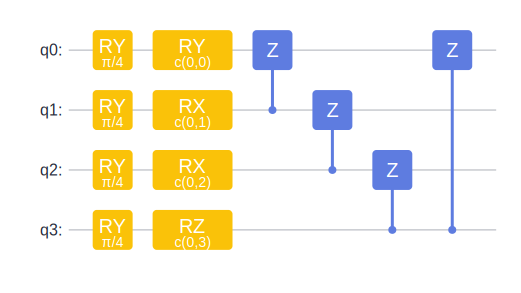

In [3]:
'''
先搭建一个比特数为4、层数为6的线路，并打印出这个线路的前12个量子门。
'''
n = 4
p = 6
circ = init_state(n) + bpansatz(n, p)
circ[:12].svg()

接着我们创建一个度为2、4个节点的随机正则图

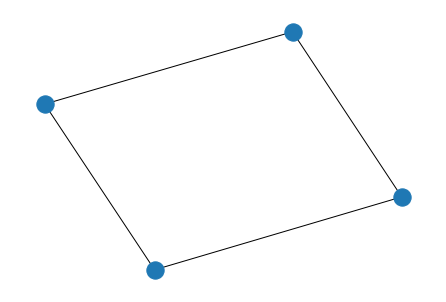

In [4]:
graph = nx.random_graphs.random_regular_graph(2, n)
nx.draw(graph)

接着，我们调用刚才写好的```train()```方法

In [5]:
s2list, costlist, gradlist = train(
            HeisenbergModel(1, 1, graph=graph),
            circ,
            steps=100,
            eta=1e-1,
            list_qubits2keep=[0, 1],
        )

100%|██████████| 100/100 [00:05<00:00, 16.95it/s]


接着使用```matplotlib.pyplot```绘图

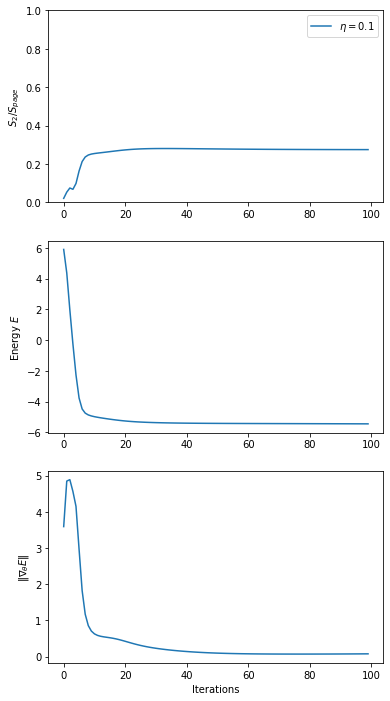

In [6]:
fig, axs = plt.subplots(3, figsize=(6, 12))
axs[0].plot(np.array(s2list) / (s_page(2, 6)), label=(r'$\eta=$' + f'{1e-1}'))
axs[1].plot(costlist)
axs[2].plot(gradlist)
axs[0].set(ylabel=r'$S_2 / S_{page}$',
               ylim=(0, 1))
axs[1].set(ylabel=r'Energy $E$')
axs[2].set(ylabel=r'$\Vert \nabla_\theta E \Vert$',
            xlabel='Iterations')
axs[0].legend(loc='upper right')

受限于```notebook```的运行时长，文章的主要复现结果存放在```images```目录中，结果展示在```README.md```的结尾。